# Viewing the dataset

This notebook demonstrates how to access metadata and arrays from the HDF5 dataset.

In [31]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm import tqdm

Make sure to update the filepath in the block below!

In [2]:
h5_filepath = '/data/bwedig/mejiro/roman_data_challenge_rung_1_dev/06/roman_data_challenge_rung_1_v_0_1.h5'  # TODO update this path!
f = h5py.File(h5_filepath, 'r')

The dataset is structured in the following way:

* `images`
    * `strong_lens_00000001`
        * `exposure_00000001_F106` dataset with the F106 exposure, a (91, 91) array
        * `exposure_00000001_F129`
        * ...
    * `strong_lens_00000002` dataset with the SNR per pixel, a (91, 91) array

In [3]:
# print all attributes for the root group
for key, value in f.attrs.items():
    print(f"{key}: {value}")

author: ['bwedig@europa.physics.wustl.edu' 'username@host for calculation']
created: 2025_09_05-01_33_36_AM
dataset_version: 0.1
galsim_version: ['2.5.1' 'GalSim version']
lenstronomy_version: ['1.13.2' 'lenstronomy version']
mejiro_version: ['2.0.0' 'mejiro version']
slsim_version: ['0.1.0' 'SLSim version']
stpsf_version: ['2.1.0' 'STPSF version']


The `images` group contains a group for each strong lens.

In [4]:
# list the first 10 groups in the 'images' group
images_group = f['images']
pprint(list(images_group.keys())[:10])

['strong_lens_00000000',
 'strong_lens_00000001',
 'strong_lens_00000002',
 'strong_lens_00000003',
 'strong_lens_00000004',
 'strong_lens_00000005',
 'strong_lens_00000006',
 'strong_lens_00000007',
 'strong_lens_00000008',
 'strong_lens_00000009']


Each strong lens group contains the exposures in each filter. It also carries information about the system (redshifts, Einstein radius, etc.) and its observation (Roman detector, detector position).

In [5]:
strong_lens = images_group['strong_lens_00000000']

for attr_key, attr_value in strong_lens.attrs.items():
    print(f"{attr_key}: {attr_value}")

print(f'\nData: {list(strong_lens.keys())}')

LOS_normalization: ['1.0' 'See pyHalo documentation']
detector: ['1' 'Detector']
detector_position_x: ['3679' 'Detector X position']
detector_position_y: ['2862' 'Detector Y position']
log_mhigh: ['12' 'See pyHalo documentation']
log_mlow: ['6' 'See pyHalo documentation']
main_halo_mass: ['74368501329612.03' 'Lens galaxy main halo mass [M_sun]']
mu: ['4.034866392201909' 'Flux-weighted magnification of source']
r_tidal: ['0.5' 'See pyHalo documentation']
sigma_sub: ['0.055' 'See pyHalo documentation']
sigma_v: ['223.67201701693105' 'Lens galaxy velocity dispersion [km/s]']
substructure: ['True' 'Is substructure present in this lens?']
theta_e: ['2.3910665582424486' 'Einstein radius [arcsec]']
uid: ['00000000' 'Unique identifier for system assigned by mejiro']
z_lens: ['0.3069999999999998' 'Lens galaxy redshift']
z_source: ['3.1834657459216733' 'Source galaxy redshift']

Data: ['exposure_00000000_F106', 'exposure_00000000_F129', 'exposure_00000000_F158']


The attributes of each exposure contains filter-specific quantities such as magnitudes and SNR.

In [6]:
for attr_key, attr_value in strong_lens['exposure_00000000_F106'].attrs.items():
    print(f"{attr_key}: {attr_value}")

exposure_time: ['642' 'Exposure time [seconds]']
filter: ['F106' 'Filter']
fov: ['10.01' 'Field of view [arcsec]']
lens_magnitude: ['17.126760111117747' 'Lens galaxy magnitude']
lensed_source_magnitude: ['21.913372486183434' 'Lensed source galaxy magnitude']
pixel_scale: ['0.11' 'Pixel scale [arcsec/pixel]']
snr: ['35.589915961289776' 'Signal-to-noise ratio']
source_magnitude: ['23.427945382099946' 'Unlensed source galaxy magnitude']
units: ['Counts/sec' 'Units of pixel values']


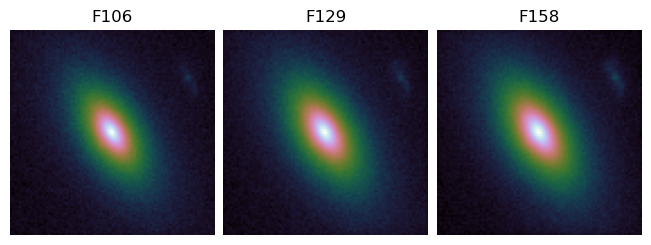

In [7]:
_, ax = plt.subplots(1, len(list(strong_lens.keys())), constrained_layout=True)

for i, (data_key, data_value) in enumerate(strong_lens.items()):
    ax[i].imshow(np.log10(data_value), cmap='cubehelix')
    ax[i].set_title(strong_lens[data_key].attrs['filter'][0])
    ax[i].axis('off')

plt.show()

# Example: create a TensorFlow Dataset from F129 exposures labeled with `substructure` flag

In [29]:
from scipy.optimize import minimize

def process_image(image):
    # normalize the image to the range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # apply gamma correction
    gamma = find_gamma(image, desired_median=0.2)
    return np.power(image, gamma)


def objective_function(gamma, image, desired_median):
    gamma_corrected_image = np.power(image, gamma)
    median_value = np.median(gamma_corrected_image)
    return (median_value - desired_median)**2


def find_gamma(image, desired_median=0.2, initial_gamma=0.7):
    result = minimize(objective_function, initial_gamma, args=(image, desired_median), method='Nelder-Mead')
    return result.x[0]

In [32]:
filter = 'F129'

data, labels = [], []
for strong_lens_group in tqdm(images_group.keys()):
    id = images_group[strong_lens_group].attrs['uid'][0]
    substructure_flag = images_group[strong_lens_group].attrs['substructure'][0]
    exposure = images_group[strong_lens_group][f'exposure_{id}_{filter}']

    # do some pre-processing
    exposure = process_image(exposure)

    data.append(exposure)
    labels.append(1 if substructure_flag == 'True' else 0)

print(f'data: {np.array(data).shape}, labels: {np.array(labels).shape}')

  0%|          | 46/10274 [00:00<00:44, 227.67it/s]/tmp/ipykernel_1161444/1441633198.py:13: RuntimeWarning: divide by zero encountered in power
  gamma_corrected_image = np.power(image, gamma)
100%|██████████| 10274/10274 [00:43<00:00, 233.70it/s]


data: (10274, 91, 91), labels: (10274,)


/tmp/ipykernel_1161444/1125555986.py:5: RuntimeWarning: divide by zero encountered in log10
  ax[i // grid_size, i % grid_size].imshow(np.log10(exposure), cmap='cubehelix')


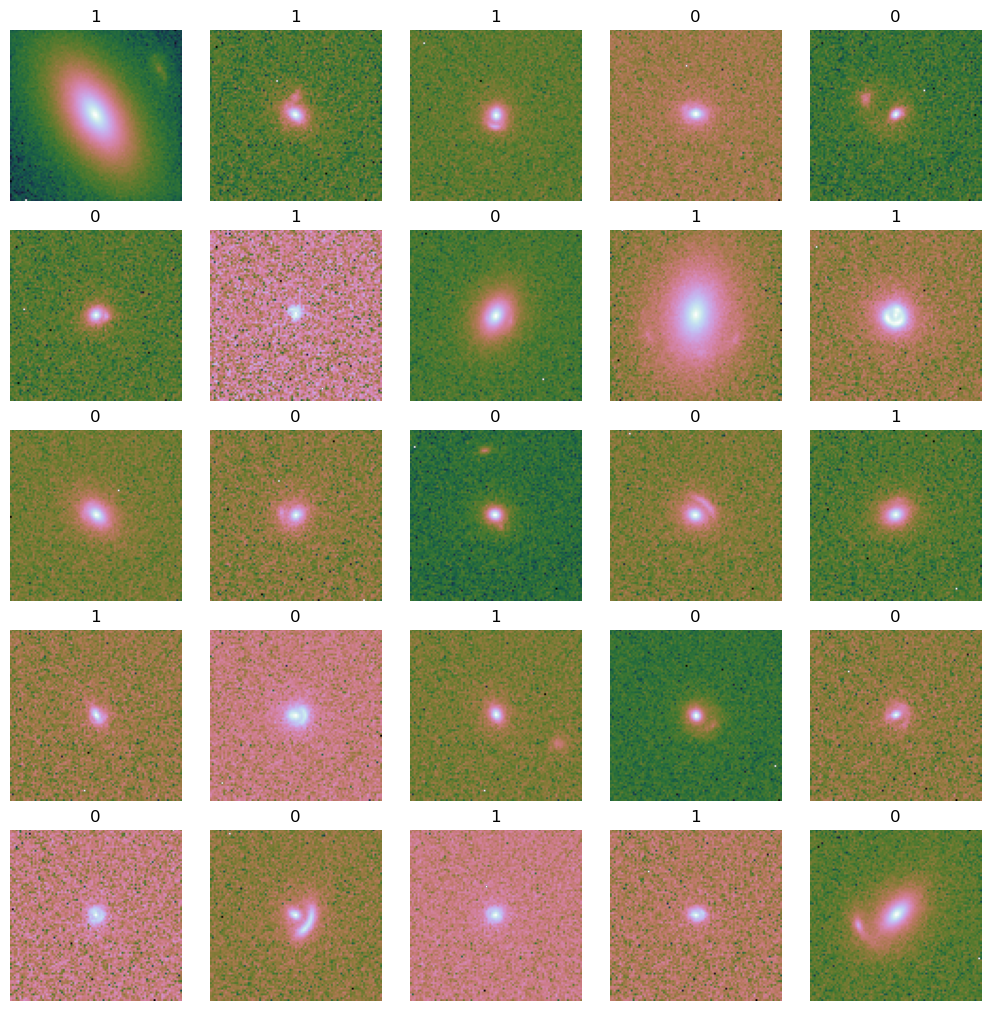

In [33]:
grid_size = 5
_, ax = plt.subplots(grid_size, grid_size, figsize=(10, 10), constrained_layout=True)

for i, (exposure, substructure_flag) in enumerate(zip(data[:grid_size ** 2], labels[:grid_size ** 2])):
    ax[i // grid_size, i % grid_size].imshow(np.log10(exposure), cmap='cubehelix')
    ax[i // grid_size, i % grid_size].set_title(substructure_flag)
    ax[i // grid_size, i % grid_size].axis('off')

plt.show()

In [34]:
import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score

ds = tf_data.Dataset.from_tensor_slices((data, labels))
ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

In [35]:
# Calculate split sizes
total_size = len(labels)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
print(f'end={total_size}, train={train_size}, val={val_size}, test={test_size}')

# Split the dataset
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

print(f"Train size: {train_ds.cardinality()}, Val size: {val_ds.cardinality()}, Test size: {test_ds.cardinality()}")

end=10274, train=7191, val=2054, test=1029
Train size: 7191, Val size: 2054, Test size: 1029


In [36]:
# data_augmentation_layers = [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
# ]

# def data_augmentation(images):
#     for layer in data_augmentation_layers:
#         images = layer(images)
#     return images

# # Apply `data_augmentation` to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf_data.AUTOTUNE,
# )

In [37]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.batch(32).prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf_data.AUTOTUNE)

In [41]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    num_bands = input_shape[2]

    # Entry block
    x = layers.Conv2D(128, num_bands, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(num_bands, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, num_bands, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(41, 41, 5), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

In [47]:
epochs = 100

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  # Or "/cpu:0" if no GPU  # MirroredStrategy()
with strategy.scope():
    model = make_model(input_shape=(91, 91, 1), num_classes=2)
    # keras.utils.plot_model(model, show_shapes=True)

    model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )

    callbacks = [
        # keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    ]
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - acc: 0.5102 - loss: 0.7110 - val_acc: 0.5273 - val_loss: 0.6917
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - acc: 0.5158 - loss: 0.6963 - val_acc: 0.5029 - val_loss: 0.6963
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - acc: 0.5193 - loss: 0.6965 - val_acc: 0.5219 - val_loss: 0.6923
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - acc: 0.5185 - loss: 0.6948 - val_acc: 0.5287 - val_loss: 0.6950
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - acc: 0.5134 - loss: 0.6965 - val_acc: 0.5088 - val_loss: 0.6926
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - acc: 0.5171 - loss: 0.6969 - val_acc: 0.5321 - val_loss: 0.6911
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - acc: 0.5093 - loss: 0.6950 - val_acc: 0.5161 - val_loss: 0.6962
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - acc: 0.5241 - loss: 0.6958 - val_acc: 0.5409 - val_loss: 0.6919
Epoch 9/100
225/225 ━━━━━━━━━━━━━━━━━━━━

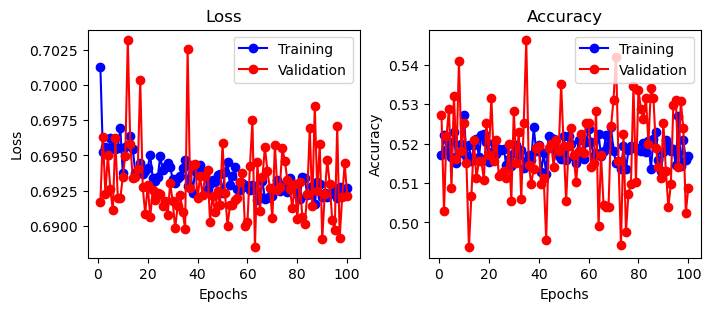

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

_, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
epoch_list = range(1, len(loss) + 1)

ax[0].plot(epoch_list, loss, 'bo-', label='Training')
ax[0].plot(epoch_list, val_loss, 'ro-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(epoch_list, accuracy, 'bo-', label='Training')
ax[1].plot(epoch_list, val_accuracy, 'ro-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
# ax[1].set_ylim(0, 1)
ax[1].legend()

plt.show()

In [49]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6919596195220947
Test accuracy: 0.5189504623413086


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


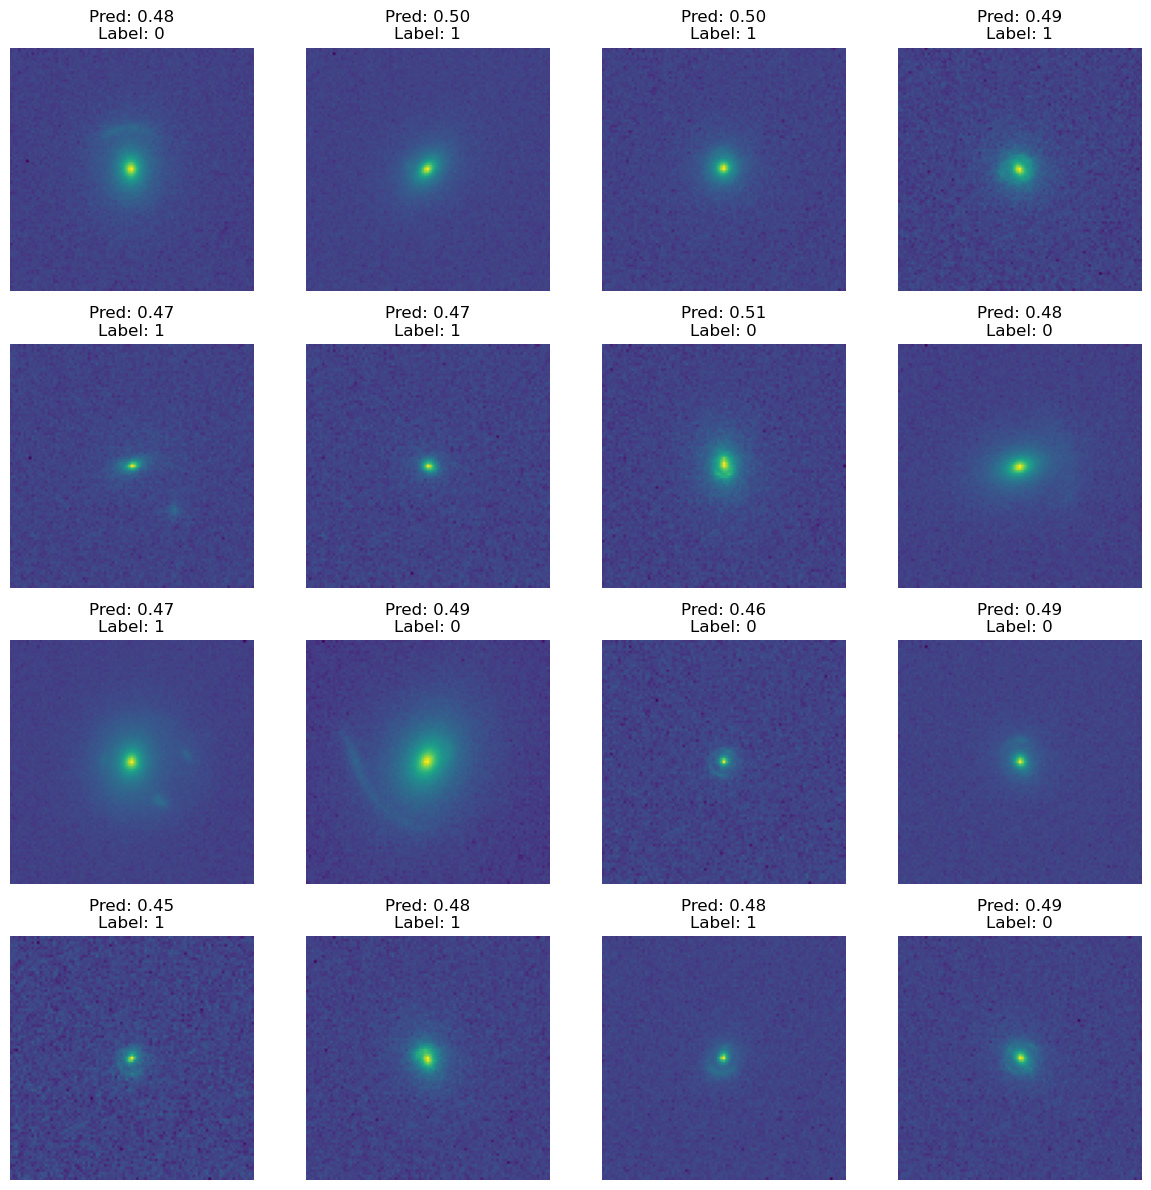

In [50]:
plt.figure(figsize=(12, 12))
for idx, (images_batch, labels_batch) in enumerate(test_ds.take(1)):
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    for i in range(min(16, images_batch.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy())
        plt.title(f"Pred: {probs[i]:.2f}\nLabel: {int(labels_batch[i])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

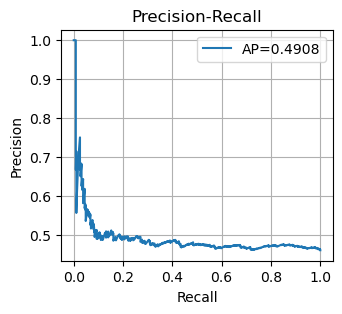

In [51]:
# Collect predictions and true labels from test_ds
y_true = []
y_scores = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch, verbose=0)
    probs = keras.ops.sigmoid(preds).numpy().flatten()  # Use sigmoid to get probabilities
    y_scores.extend(probs)
    y_true.extend(labels_batch.numpy().flatten())

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(3.5, 3))
plt.plot(recall, precision, label=f'AP={ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()